Epoch 1/10, 梯度均值（从浅到深）: ['0.000205', '0.000205', '0.000176', '0.000160', '0.001043']
Epoch 2/10, 梯度均值（从浅到深）: ['0.000207', '0.000198', '0.000176', '0.000159', '0.000803']
Epoch 3/10, 梯度均值（从浅到深）: ['0.000208', '0.000202', '0.000179', '0.000150', '0.000835']
Epoch 4/10, 梯度均值（从浅到深）: ['0.000204', '0.000210', '0.000171', '0.000168', '0.001203']
Epoch 5/10, 梯度均值（从浅到深）: ['0.000220', '0.000219', '0.000205', '0.000192', '0.001145']
Epoch 6/10, 梯度均值（从浅到深）: ['0.000222', '0.000200', '0.000170', '0.000174', '0.001083']
Epoch 7/10, 梯度均值（从浅到深）: ['0.000204', '0.000201', '0.000171', '0.000140', '0.000688']
Epoch 8/10, 梯度均值（从浅到深）: ['0.000206', '0.000202', '0.000181', '0.000161', '0.000992']
Epoch 9/10, 梯度均值（从浅到深）: ['0.000223', '0.000206', '0.000166', '0.000140', '0.000773']
Epoch 10/10, 梯度均值（从浅到深）: ['0.000237', '0.000235', '0.000213', '0.000202', '0.001240']


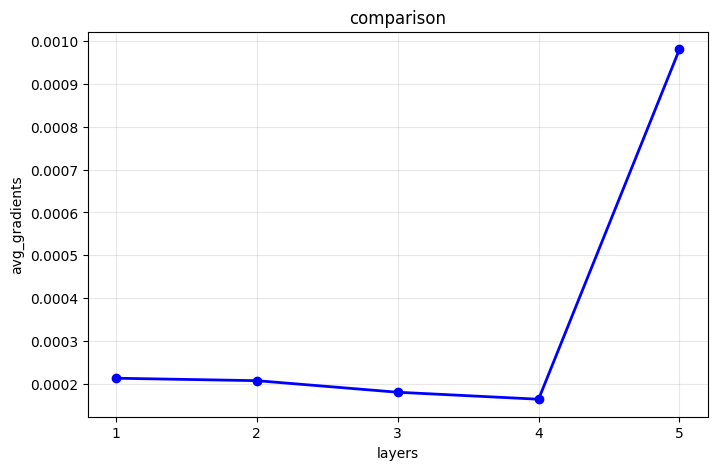

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. 数据准备（使用MNIST数据集）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST标准化
])

# 加载训练集（仅用训练集即可，无需测试集）
train_dataset = datasets.MNIST(
    root='/data/nieruichen/Deep-Learning-Intro-Assignments/MNIST_data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

# 2. 定义多层全连接网络
class SimpleMLP(nn.Module):
    def __init__(self, layers=10, hidden_dim=128):
        super().__init__()
        # 输入层（28*28=784）→ 多层隐藏层 → 输出层（10类）
        self.layers = nn.ModuleList()
        input_dim = 784
        for _ in range(layers):
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            self.layers.append(nn.ReLU())  # 用ReLU激活
            input_dim = hidden_dim
        self.fc_out = nn.Linear(hidden_dim, 10)  # 输出层

    def forward(self, x):
        x = x.view(-1, 784)  # 展平图像
        for layer in self.layers:
            x = layer(x)
        x = self.fc_out(x)
        return x

# 3. 初始化组件
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleMLP(layers=4).to(device)  # 4层隐藏层（共5层可训练层）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 无动量SGD，避免干扰

# 4. 训练并记录梯度
gradient_stats = []  # 存储各层梯度绝对值均值（格式：[epoch][layer] = 均值）

for epoch in range(10):  # 训练10个epoch
    model.train()
    epoch_gradients = []  # 记录当前epoch各层的梯度均值
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # 清零梯度
        output = model(data)
        loss = criterion(output, target)
        loss.backward()  # 反向传播计算梯度
        
        # 只记录第一个batch的梯度（避免冗余，趋势一致）
        if batch_idx == 0:
            # 遍历所有可训练层（Linear层）
            layer_idx = 0
            for module in model.modules():
                if isinstance(module, nn.Linear):
                    # 计算当前层权重梯度的绝对值均值
                    grad_mean = module.weight.grad.abs().mean().item()
                    epoch_gradients.append(grad_mean)
                    layer_idx += 1
            break  # 只处理第一个batch
    
    gradient_stats.append(epoch_gradients)
    print(f'Epoch {epoch+1}/10, 梯度均值（从浅到深）: {[f"{g:.6f}" for g in epoch_gradients]}')

# 5. 可视化结果
# 计算所有epoch的梯度均值（按层）
avg_gradients = np.mean(gradient_stats, axis=0)
layers = np.arange(1, len(avg_gradients)+1)  # 层索引（1,2,3,...）

plt.figure(figsize=(8, 5))
plt.plot(layers, avg_gradients, 'o-', color='b', linewidth=2)
plt.xlabel('layers')
plt.ylabel('avg_gradients')
plt.title('comparison')
plt.grid(alpha=0.3)
plt.xticks(layers)
plt.show()

 Learn the basic usage of torchvision.datasets.MNIST and torchvision.transforms using grad_cmp.ipynb
 , visualize the gradient comparison results across different network layers, and observe changes by 
modifying model parameters.